In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [3]:
# Import data
raw_data = pd.read_csv("../Datasets/IMDB_Dataset.csv")

# Transform all reviews to lower case only
raw_data["review"] = raw_data["review"].apply(lambda x: x.lower())

# Get all positive words
positive_words_file = open("../Datasets/positive-words.txt", "r")
positive_words = positive_words_file.read().split("\n")
positive_words = list(map(str.lower, positive_words[35:-1]))
positive_words = set(positive_words)

# Get all negative words
negative_words_file = open("../Datasets/negative-words.txt", "r")
negative_words = negative_words_file.read().split("\n")
negative_words = list(map(str.lower, negative_words[35:-1]))
negative_words = set(negative_words)

# Combine all positive and negative words into one set
sentiment_words = positive_words.union(negative_words)

In [4]:
# Create TF-IDF matrix based on sentiment words
vectorizer = TfidfVectorizer(vocabulary = sentiment_words)

tf_idf_matrix = vectorizer.fit_transform(raw_data["review"])
tf_idf_matrix = tf_idf_matrix.toarray()
tf_idf_matrix.shape

(50000, 6786)

In [47]:
# Find principal components of all dimensions (6786)
pca = PCA() # Warning: this takes like 8-9 minutes
principal_components = pca.fit(tf_idf_matrix)

Text(0, 0.5, 'Cumulative Variance Ratio')

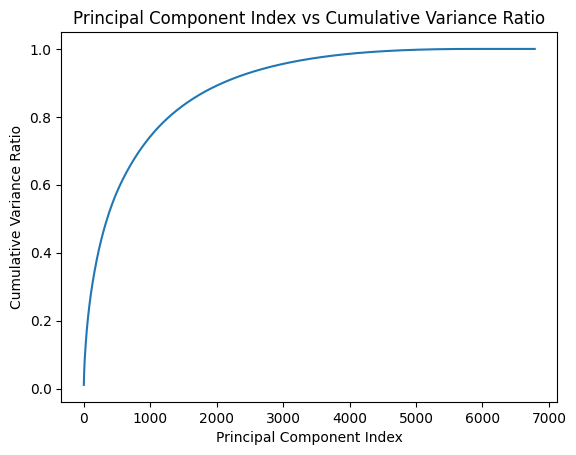

In [48]:
# Plot cumulative variance ratio vs # of principal component indices
components = list(range(1, 6787))
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

plt.plot(components, cumulative_variance_ratio)
plt.title("Principal Component Index vs Cumulative Variance Ratio")
plt.xlabel("Principal Component Index")
plt.ylabel("Cumulative Variance Ratio")

In [5]:
# Choosing 1300 components as that captures roughly 0.80 cumulative variance ratio
pca2 = PCA(n_components = 1300)

transformed_features = pca2.fit_transform(tf_idf_matrix)

In [14]:
# Very basic example of logistic regression, don't use this example use Anthony's impl
sentiment = raw_data["sentiment"]
X_train, X_test, y_train, y_test = train_test_split(transformed_features, sentiment, train_size = 0.5, random_state = 1, shuffle = True)

log_reg = LogisticRegression()
model = log_reg.fit(X_train, y_train)
model.score(X_test, y_test) # ratio of correct classification for logistic regression

0.85612

In [ ]:
# For saving the transformed data
df = pd.DataFrame(transformed_features)
df.to_csv("transfored_data.csv")

In [21]:
# Decision Tree Model with max depth 10
tree_classifier = DecisionTreeClassifier(max_depth = 10)
tree_model = tree_classifier.fit(X_train, y_train)
tree_model.score(X_test, y_test)

0.75316